### Modeling Water Quality of the Potomac River
#### Predicting Total Phosphorus Levels 

**Imports**

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# code modified from Mike Blow's RandomForestRegressor model

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [4]:
np.random.seed(20200908)

In [5]:
water = pd.read_csv('./data/WQ_FULL_Parameters.csv')

In [8]:
params = [col for col in water if 'Parameter' in col]

**Transform Variables**

In [9]:
# create dummy variables for TideStage
water = pd.get_dummies(water, columns=['TideStage'], prefix='tide', drop_first=True)

In [10]:
# transform Date_Time into datetime object
water['Date_Time'] = pd.to_datetime(water['Date_Time'])

In [11]:
water['Date_Time'].dtype

dtype('<M8[ns]')

In [12]:
# create variables for year and for month
water['Years'] = water['Date_Time'].dt.year
water['Months'] = water['Date_Time'].dt.month

**Correlation Matrix**

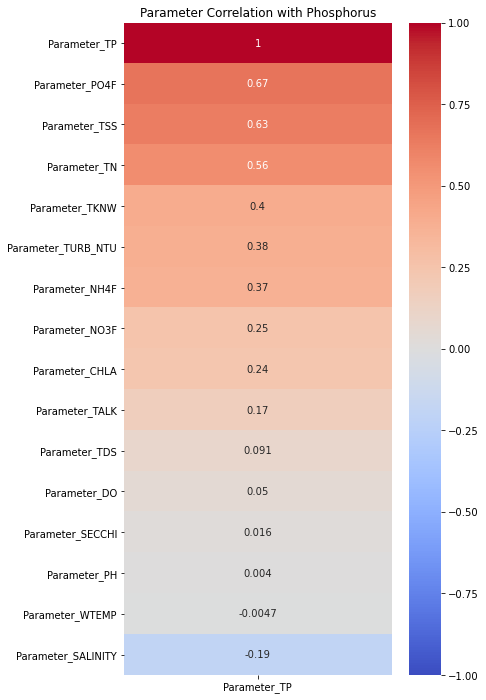

In [15]:
# heatmap to display correlation matrix
plt.figure(figsize=(6, 12))
plt.title('Parameter Correlation with Phosphorus')
sns.heatmap(water[params].corr()[['Parameter_TP']].sort_values('Parameter_TP', ascending=False),
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            annot=True);
plt.show();

### Random Forest Classifier
- categorical total phosphorus as y variable

Categories:
- 0.01 - 0.03 mg/L - uncontaminated freshwater
- 0.025 - 0.1 mg/L - level at which plant growth is stimulated
- \> 0.1 mg/L - accelerated growth and consequent problems


[source](https://water-research.net/index.php/phosphates)

In [16]:
# function to create categorical total phosphorus

def categorical_TP(column):
    value = 0
    if column < 0.03:
        # value for uncontaminated water = 1
        value = 1
    elif column <= 0.1:
        # value for stimulated plant growth = 2
        value = 2
    elif column > 0.1:
        # value for problematic total phosphorus level = 3
        value = 3
    return value

In [17]:
# create categorical TP variable
water['Categorical_TP'] = water['Parameter_TP'].map(categorical_TP)

In [18]:
water['Categorical_TP'].isna().sum()

0

In [22]:
# columns to drop from features
col_to_drop = ['Date_Time', 'Agency', 'Cruise', 'Database', 'HUC12', 'Latitude', 'Layer', 'Longitude', 'Method', 'Program', 'Project', 
               'SampleReplicateType', 'SampleType', 'Source', 'Station', 'TierLevel', 'Unit', 'Point', 'FIPS_', 'COUNTY_', 'STATE_', 'Parameter_TP',
               'Categorical_TP', 'SampleId', 'HUCNAME_']

In [23]:
X = water.drop(columns=col_to_drop)

y = water['Categorical_TP']

In [24]:
X.columns

Index(['SampleDepth', 'HUC12_', 'TotalDepth', 'Parameter_CHLA', 'Parameter_DO',
       'Parameter_NH4F', 'Parameter_NO3F', 'Parameter_PH', 'Parameter_PO4F',
       'Parameter_SALINITY', 'Parameter_SECCHI', 'Parameter_TALK',
       'Parameter_TDS', 'Parameter_TKNW', 'Parameter_TN', 'Parameter_TSS',
       'Parameter_TURB_NTU', 'Parameter_WTEMP', 'tide_Flood Tide',
       'tide_High Slack Tide', 'tide_Low Slack Tide', 'Years', 'Months'],
      dtype='object')

**Baseline Accuracy**

In [25]:
y.value_counts(normalize=True)

1    0.825206
2    0.135816
3    0.038978
Name: Categorical_TP, dtype: float64

**Model**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y)

In [27]:
rf = RandomForestClassifier()
ad = AdaBoostClassifier()

In [28]:
# parameters for RF grid search
params = {
    'n_estimators'      : [100, 500, 750],
    'min_samples_split' : [5, 10, 20]
}

In [29]:
# Set up grid search
gs = GridSearchCV(rf, 
                  param_grid=params,
                  cv = 4,
                  n_jobs = -1,
                  verbose = 2)

In [30]:
gs.fit(X_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  36 | elapsed:   55.3s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  30 out of  36 | elapsed:  5.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  5.5min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': [5, 10, 20],
                         'n_estimators': [100, 500, 750]},
             verbose=2)

In [31]:
ad_params = {
    'n_estimators' : [100, 500, 750]
}

In [32]:
# Set up grid search
ad_gs = GridSearchCV(rf, 
                  param_grid=ad_params,
                  cv = 4,
                  n_jobs = -1,
                  verbose = 2)

In [33]:
ad_gs.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  2.4min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.5min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [100, 500, 750]}, verbose=2)

# Evaluation

In [35]:
# List best hyperparameters found in Grid Search
print(gs.best_params_)
print(ad_gs.best_params_)

{'min_samples_split': 5, 'n_estimators': 750}
{'n_estimators': 750}


In [44]:
# print rf scores
print('Random Forest Scores')
print('Training accuracy: ', round(gs.score(X_train, y_train), 2))
print('Testing accuracy: ', round(gs.score(X_test, y_test), 2))
print('Cross-validated accuracy:', round(gs.best_score_, 2))

# print ada scores
print('AdaBoost Scores:')
print('Training accuracy: ', round(ad_gs.score(X_train, y_train), 2))
print('Testing accuarcy: ', round(ad_gs.score(X_test, y_test), 2))
print('Cross-validated accuracy:', round(ad_gs.best_score_, 2))

Random Forest Scores
Training accuracy:  1.0
Testing accuracy:  0.97
Cross-validated accuracy: 0.97
AdaBoost Scores:
Training accuracy:  1.0
Testing accuarcy:  0.97
Cross-validated accuracy: 0.97


In [45]:
# Grab feature names, their importance, and sort them into a dataframe.
features_df = pd.DataFrame(gs.best_estimator_.feature_importances_, X_train.columns, columns=['Importance'])
features_df.sort_values(by='Importance', ascending=False).head(15)

,Importance
Parameter_PO4F,0.243990
Parameter_TN,0.153155
Parameter_TSS,0.134304
Parameter_NH4F,0.109970
Parameter_NO3F,0.068340
Parameter_CHLA,0.048752
Parameter_TURB_NTU,0.029341
TotalDepth,0.027572
HUC12_,0.023742
Parameter_WTEMP,0.022850


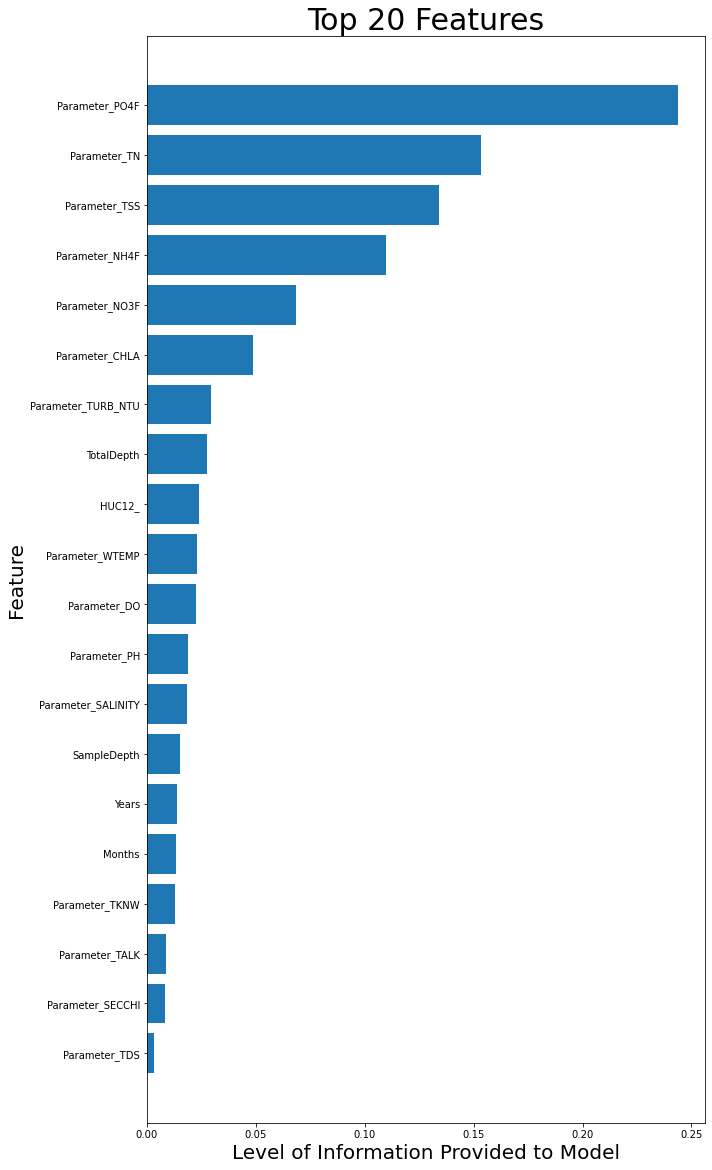

In [51]:
# plot the top features minus the top 3 ('leadership', 'leader', & 'leaders')
plt.figure(figsize=(10,20))
temp = features_df.sort_values('Importance').tail(20)
plt.barh(temp.index, temp['Importance'])
plt.title('Top 20 Features', fontsize=30)
plt.ylabel('Feature', fontsize=20)
plt.xlabel('Level of Information Provided to Model', fontsize=20);

The model is slightly overfit to the training data, however, the cross-validated accuracy score supports the 97% testing accuracy. The model seems to generalize well in predicting the total_phosphorus categories of healthy level, level of promoting plant growth, and alarmingly high level that may lead to rapid plant growth such as algea bloom and eutrophication.